In [25]:
import xarray as xr
from dask import delayed
import numpy as np

In [2]:
#open MERRA2 Reanalysis dataset
da=xr.open_dataset('https://geodesystems.com/repository/opendap/038361f9-fb9a-484c-9f1d-3623a12a47ca/entry.das') 

In [26]:
dpbyg=da.lev.copy() # make a copy of values
dpbyg.values=-1*np.gradient(da.lev*100.0)/9.8

In [28]:
def calc_CWV(q):
    CWV=(q*dpbyg).sum(dim='lev')  #should give Column Water Vapor in mm 
    CWV.name='CWV'
    return CWV

In [4]:
import holoviews as hv


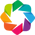

In [5]:
hv.notebook_extension('bokeh')

In [102]:
def CWV_time_sel(time):
    q=da.qv.sel(time=time,lev=850)
    #CLW=calc_CWV(q)
    return hv.Image(q) #CLW)

In [103]:
dmap=hv.DynamicMap(CWV_time_sel,kdims=['time'])
dmap.redim.values(time=dates[::5])

:DynamicMap   [time]

In [13]:
import pandas as pd

In [16]:
dates=pd.date_range('2008-01-01','2008-02-01',freq='3H')

In [29]:
s=CWV_time_sel(dates[0])

In [31]:
def regrid(variable,nlon,nlat):
    
    lon_bins=nlon
    lat_bins=nlat
    lat_gpd=variable.groupby_bins('lat',lat_bins)
    latreg=lat_gpd.mean(dim=['lat'])#,skipna=True,keep_attrs=True)
    lon_gpd=latreg.groupby_bins('lon',lon_bins)
    regrided=lon_gpd.mean(dim=['lon']) #,skipna=True,keep_attrs=True)

    regrided=regrided.rename({'lat_bins':'lat'})
    regrided=regrided.rename({'lon_bins':'lon'})
    lats=[]
    for latbin in regrided.lat.values:
        latbounds=[float(lat) for lat in str(latbin).strip(r'(])').split(',')]
        lats.append(np.mean(latbounds))
    regrided['lat']=lats    

    lons=[]
    for lonbin in regrided.lon.values:
        lonbounds=[float(lon) for lon in str(lonbin).strip(r'(])').split(',')]
        lons.append(np.mean(lonbounds))
    regrided['lon']=lons

    return regrided#.sel(lat=slice(variable.lat.min(),variable.lat.max()),lon=slice(variable.lon.min(),variable.lon.max()))


In [34]:
%time
regrid(da.qv.isel(time=1),360,181)

<xarray.DataArray 'qv' (lev: 42, lat: 45, lon: 90)>
array([[[           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan],
        ..., 
        [  1.819099e-04,   1.742906e-04, ...,   1.862984e-04,   1.883951e-04],
        [  3.788702e-04,   3.816948e-04, ...,   3.707550e-04,   3.751619e-04]],

       [[           nan,            nan, ...,            nan,            nan],
        [  1.413042e-03,   1.874108e-03, ...,   9.063897e-04,   1.067364e-03],
        ..., 
        [  2.258627e-04,   2.761653e-04, ...,   1.672006e-04,   1.829336e-04],
        [  3.510059e-04,   3.540339e-04, ...,   3.433510e-04,   3.471326e-04]],

       ..., 
       [[  4.303044e-06,   4.303044e-06, ...,   4.303095e-06,   4.303088e-06],
        [  4.301060e-06,   4.300909e-06, ...,   4.301559e-06,   4.301293e-06],
        ..., 
        [  2.486287e-06,   2.485883e-06, ...,   2.476443e-06,   2.482782e-06],
        [  2.381367e

In [44]:
import param
import parambokeh
import paramnb
from datetime import datetime

In [52]:
da.qv.to_

In [99]:
class MERRA_Time(hv.streams.Stream):
    time=param.ObjectSelector(default=datetime(2008,1,1),objects=dates)
    def make_view(self, x_range=None, y_range=None, **kwargs):
        q=da.qv.sel(time=self.time)
        hvd=hv.Dataset(q)
        dmap=hv.Image(q,kdims=['lon','lat'],streams=['self'])

                  
        return dmap

selector = MERRA_Time(name="")

In [100]:

paramnb.Widgets(selector, callback=selector.update)

hv.DynamicMap(selector.make_view, kdims=[])#, streams=[selector, RangeXY()])

<IPython.core.display.Javascript object>

ValueError: cannot select an axis to squeeze out which has size not equal to one

:DynamicMap   []

In [61]:
paramnb.Widgets(selector)

<IPython.core.display.Javascript object>

In [89]:


import param
import parambokeh

class StockExplorer(hv.streams.Stream):
    
    rolling_window = param.Integer(default=10, bounds=(1, 365))

    
    def view(self):
        
        q=da.qv.isel(time=self.rolling_window).isel(lev=10)
        return hv.Image(q) #,streams=['self'])



In [90]:
%opts Curve [width=600] {+framewise} Scatter (color='red' marker='triangle')
explorer = StockExplorer()
parambokeh.Widgets(explorer, continuous_update=True, callback=explorer.event, on_init=True)
explorer.view()

:Image   [lon,lat]   (qv)

In [88]:
time=hv.streams.Stream(name='Time',transient=False)